In [122]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide
import os
from utils import *
import pandas as pd
import cartopy.feature as cfeature
import xesmf as xe
from scipy.ndimage import gaussian_filter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from palette import *
import statsmodels.api as sm
import cmocean

# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy


#datadir = './'
datadir = '/home7/pharos/othr/cgonzale/data/iwsst_mit/1month/'
datadir_out = '/home7/pharos/othr/cgonzale/data/iwsst_mit/working/'
graphdir = '/home3/homedir7/perso/cgonzale/IWAVE/figures/Simul_MITgcm/'
bathy = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
datadir_tides = '/home2/pharos/othr/aponte/tides/HRET/'
datadir_tides2 = '/home2/pharos/othr/aponte/tides/FES2014/'
# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

palette = '/home3/homedir7/perso/cgonzale/IWAVE/script/palette/medspiration.rgb'
csst = getColorMap( rgbFile = palette )

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
Region = 'AustraliaHW'
if(Region == 'AustraliaHW'):
    fregion = 'nwa_'
elif (Region == 'Mozamb2'):
    fregion = 'mad_'

In [4]:
file='nwa_SST.nc'
dsSST = xr.open_dataset(datadir+file,chunks={'j':100})
file = 'nwa_Eta.nc'
dsSSH = xr.open_dataset(datadir+file,chunks={'j':100})

In [5]:
print(dsSST)

<xarray.Dataset>
Dimensions:  (i: 2000, j: 2000, time: 625)
Coordinates:
  * i        (i) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  * j        (j) int64 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 ...
    face     int64 ...
    XC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    YC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    rA       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    Depth    (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(625,), chunksize=(625,)>
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>
Data variables:
    SST      (time, j, i) float32 dask.array<shape=(625, 2000, 2000), chunksize=(625, 100, 2000)>


In [6]:
print(dsSSH)

<xarray.Dataset>
Dimensions:  (i: 2000, j: 2000, time: 625)
Coordinates:
  * i        (i) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  * j        (j) int64 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 ...
    face     int64 ...
    XC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    YC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    rA       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    Depth    (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(625,), chunksize=(625,)>
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>
Data variables:
    Eta      (time, j, i) float32 dask.array<shape=(625, 2000, 2000), chunksize=(625, 100, 2000)>


## Check for vivo/morto periods

In [7]:
t=dsSST.time
print(t)

<xarray.DataArray 'time' (time: 625)>
array([13132800., 13136400., 13140000., ..., 15372000., 15375600., 15379200.])
Coordinates:
    face     int64 ...
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(625,), chunksize=(625,)>
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>


In [8]:
day2second = 3600*24
t0 = 1.35e7+(3600*36)+day2second
tf= t0+2*day2second

In [9]:
Tmean_xy = dsSST['SST'].mean(dim=['i','j'])

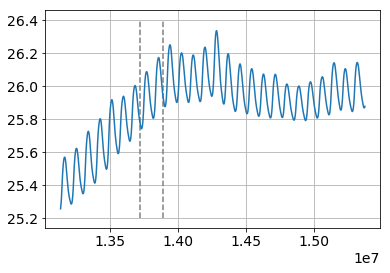

In [10]:

plt.plot(t,Tmean_xy)
plt.vlines(x=t0, ymin=25.2,ymax=26.4,linestyle='dashed',colors='gray')
plt.vlines(x=tf, ymin=25.2,ymax=26.4,linestyle='dashed',colors='gray')
plt.grid()

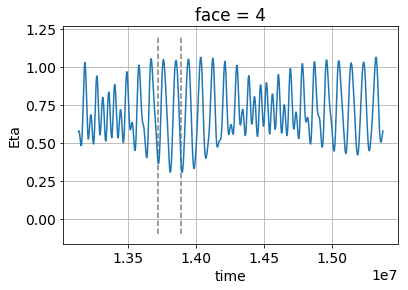

In [11]:
Eta_mean_xy = dsSSH['Eta'].mean(dim=['i','j'])
Eta_mean_xy.plot()
plt.vlines(x=t0, ymin=-0.1,ymax=1.2,linestyle='dashed',colors='gray')
plt.vlines(x=tf, ymin=-0.1,ymax=1.2,linestyle='dashed',colors='gray')
plt.grid()

### Select vivo period (2days) t_0:t_f

In [12]:
#Select region for HW

In [13]:
if (Region == 'AustraliaHW'):
    latmin_z = -22 #-14,-13
    latmax_z = -13#-12, -7
    lonmin_z =  114#52,49
    lonmax_z =  124#55,53
    vmin = 22
    vmax = 29
    vmax_grad = 0.1
    vmax_tw=0.05
    it=1
   

sst2d_t = dsSST['SST'].where(dsSST['SST']['XC']>=lonmin_z, drop=True)
sst2d_t = sst2d_t.where(sst2d_t['XC']<=lonmax_z, drop=True)
sst2d_t = sst2d_t.where(sst2d_t['YC']<=latmax_z, drop=True)
sst2d_t = sst2d_t.where(sst2d_t['YC']>=latmin_z, drop=True)

In [14]:
print(sst2d_t)

<xarray.DataArray (time: 625, j: 492, i: 480)>
dask.array<shape=(625, 492, 480), dtype=float32, chunksize=(625, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(625,), chunksize=(625,)>
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>


In [15]:
#select in time
sst2d_2days=sst2d_t.sel(time=slice(t0,tf))
print(sst2d_2days)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float32, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [16]:
t = sst2d_2days.time

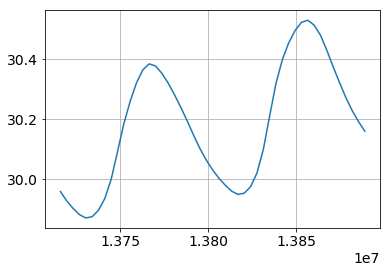

In [17]:
Tmean_xy_2days =sst2d_2days.mean(dim=['i','j'])
plt.plot(t,Tmean_xy_2days)
plt.grid()

Text(0,0.5,'SST lon=114.19,-21.82')

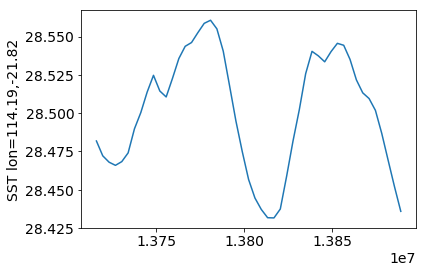

In [18]:
## select one pixel
sst_t=sst2d_2days.sel(i=2986,j=2435)
#sst_t=sst2d_2days.sel(i=2985,j=2436)#first
plt.plot(t,sst_t)
plt.ylabel('SST lon=114.19,-21.82')
#sst_t.plot() #too slow

In [19]:
print(sst_t.XC.values,sst_t.YC.values)

114.21875 -21.841473


In [20]:
dt = t[1]-t[0]
print(dt.values)

3600.0


In [21]:
omega_M2=1.923*cpd# rad/s

In [22]:
1.923*cpd

0.00013984450631604565

In [23]:
sst_t_mean=sst_t.mean()
print(sst_t_mean.values)

28.501234


In [24]:
def get_slow_fast (v, omega=omega_M2, omega2=None, verbose = False, coeff = False):
    """ Extract the tidal signal with a harmonic analysis 
    The fit looks like: v = v0 + v1 x t + sum( vi_c cos(omega x t) + vi_s sin(omega x t))
    or:  v = v0 + v1 x t + sum( vi_c cos(omega x t) + vi_s sin(omega x t)) + sum( vi_c cos(omega2 x t) + vi_s sin(omega2 x t))
        Parameters
    ----------
        v:
            signal to decompose
        t:
            time line in seconds
        omega:
            tidal frequency in rad/s (M2 = 1.39844e-4)
        omega2:
            diurnal frequency in rad/s (M2/2 = 0,69922e-4)
    """
    t = v.time 
    t+= -t.mean() 
    Nt = t.shape
    if (omega2 is not None):
        Xx = [t*0.+1., t , np.cos(omega*t), np.sin(omega*t), np.cos(omega2*t), np.sin(omega2*t)]
        X = np.vstack((np.ones_like(t),t,np.cos(omega*t),np.sin(omega*t),np.cos(omega2*t),np.sin(omega2*t)))
    else:
        X = np.vstack((np.ones_like(t),t,np.cos(omega*t),np.sin(omega*t)))
        Xx = [t*0.+1., t , np.cos(omega*t), np.sin(omega*t)]
    
    X=X.transpose()
    Mx=np.linalg.inv(X.transpose().dot(X))
    
   
    
    XtY = [(x*v*Nt).mean(dim='time') for x in Xx]

    B = []
    for i in range(len(Xx)):
        B.append(XtY[0]*0.)
        for j in range(len(Xx)):
            B[-1] += Mx[i,j]*XtY[j]
    
    vslow = B[0]*Xx[0] + B[1]*Xx[1]
    vfast = B[2]*Xx[2] + B[3]*Xx[3]
    if(verbose):
        if (omega2 is None):
            print('B:',B[0].sel(i=2986,j=2435).values, B[1].sel(i=2986,j=2435).values,B[2].sel(i=2986,j=2435).values,B[3].sel(i=2986,j=2435).values)
        else:
            print('B:',B[0].sel(i=2986,j=2435).values, B[1].sel(i=2986,j=2435).values,B[2].sel(i=2986,j=2435).values,\
                  B[3].sel(i=2986,j=2435).values,B[4].sel(i=2986,j=2435).values,B[5].sel(i=2986,j=2435).values)
    if (omega2 is not None):
        vfast2 = B[4]*Xx[4] + B[5]*Xx[5]
    if (omega2 is not None):
        if (coeff):
            return vslow, vfast, vfast2, B[0],B[1], B[2], B[3], B[4], B[5]
        else:
            return vslow, vfast, vfast2
    else:
        if (coeff):
            return vslow, vfast, B[0],B[1], B[2], B[3]
        else:
            return vslow, vfast

vslow, vfast = get_slow_fast(sst_t)
#Xty_func=get_slow_fast(sst_t)
#print(Xty_func)
#print(vslow)
#vslow.plot()
#vfast.plot()

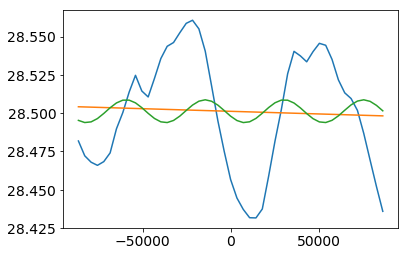

In [25]:
plt.plot(t,sst_t)
plt.plot(t,vslow)
plt.plot(t,vfast+sst_t_mean)

# Decompose semidiurnal component

In [26]:
vslow_semi, vfast_semi = get_slow_fast(sst2d_2days,verbose = True)


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


B: 28.501173152375646 -3.436088037377364e-08 -0.0032315377877727425 -0.006723917003984069


In [27]:
print(vslow_semi)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


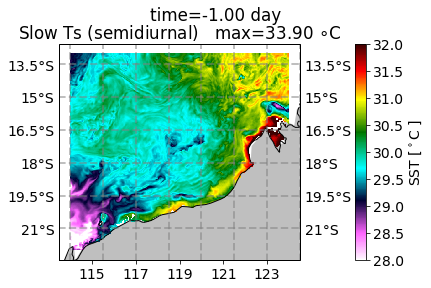

In [28]:
fig = plt.figure()
#plot wave SST
t0=0

pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_semi.XC,vslow_semi.YC,vslow_semi[:,:,t0], \
                transform = ccrs.PlateCarree(),cmap=csst,vmax=32,vmin=28)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C ]')
ax.set_title(r'Slow Ts (semidiurnal)   max=%.2f $\circ$C' %(np.abs(vslow_semi[:,:,t0]).max(skipna=True) ))
thour=(vslow_semi.time[t0]/3600)
tday=(vslow_semi.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)


In [29]:
#vslow_semi.isel(time=0).plot(vmin=28,vmax=32)#too slow (20min)

In [30]:
print(vslow_semi.name)

None


In [31]:
vslow_semi.name = 'SST_slow_semi'
vfast_semi.name = 'SST_fast_semi'

In [32]:
print(vslow_semi.name,vfast_semi.name)

SST_slow_semi SST_fast_semi


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


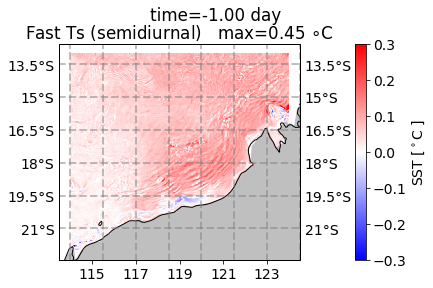

In [33]:
fig = plt.figure()
#plot wave SST
t0=0

pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vfast_semi.XC,vfast_semi.YC,vfast_semi[:,:,t0], \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.3,vmin=-0.3)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C ]')
ax.set_title(r'Fast Ts (semidiurnal)   max=%.2f $\circ$C' %(np.abs(vfast_semi).max(skipna=True) ))
thour=(vfast_semi.time[t0]/3600)
tday=(vfast_semi.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)


In [34]:
#vfast_semi.isel(time=0).plot(vmin=-0.3,vmax=0.3, cmap = 'bwr')

In [35]:
#vfast_semi_ij=vfast_semi.sel(i=2985,j=2436) #first try but invalid value for zonal component
#vslow_semi_ij=vslow_semi.sel(i=2985,j=2436)
vfast_semi_ij=vfast_semi.sel(i=2986,j=2435)
vslow_semi_ij=vslow_semi.sel(i=2986,j=2435)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


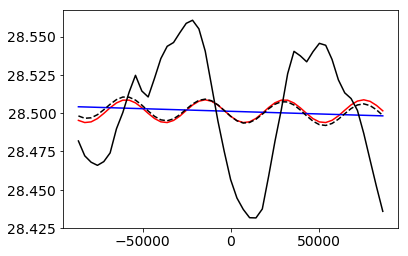

In [36]:
plt.plot(t,vfast_semi_ij+sst_t_mean,c='r')
plt.plot(t,vslow_semi_ij,c='b')
plt.plot(t,sst_t,c='k')
plt.plot(t,vfast_semi_ij+vslow_semi_ij,c='k',linestyle='--')

In [37]:
vslow_all, vfast_all, vfast_all2 = get_slow_fast(sst_t,omega=omega_M2,omega2 = omega_M2/2)

In [38]:
print(vslow[1])

<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    i        int64 2986
    j        int64 2435
    face     int64 4
    XC       float32 dask.array<shape=(), chunksize=()>
    YC       float32 dask.array<shape=(), chunksize=()>
    rA       float32 dask.array<shape=(), chunksize=()>
    Depth    float32 dask.array<shape=(), chunksize=()>
    time     float64 -8.28e+04
    dtime    datetime64[ns] dask.array<shape=(), chunksize=()>
    iters    int64 dask.array<shape=(), chunksize=()>


### Save NetCDF

In [39]:
print(vslow_semi)

<xarray.DataArray 'SST_slow_semi' (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [40]:
file_out = datadir_out+'fast_SST_semidiurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)

##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [41]:

file_out = datadir_out+'slow_SST_semidiurnal.nc'

if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [42]:
def skill(vtrue,v):
    """ compute the skill of a reconstruction (v) of the vtrue signal
    """
   
    dif_vtrue_v = vtrue - v
    skill = 1. - dif_vtrue_v.std('time')/vtrue.std('time')
    
    
    return skill

In [43]:
sst_recons_semi= vslow_semi+vfast_semi
skill_semi = skill(sst2d_2days, sst_recons_semi)

In [44]:
print(skill_semi)

<xarray.DataArray (j: 492, i: 480)>
dask.array<shape=(492, 480), dtype=float64, chunksize=(73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


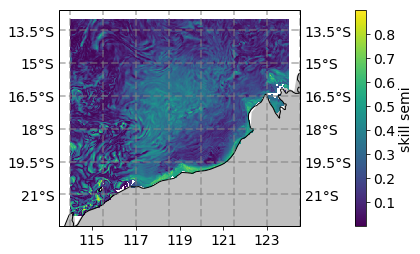

In [45]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(skill_semi.XC,skill_semi.YC,skill_semi, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'skill semi')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

In [46]:
#skill_semi.plot()

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


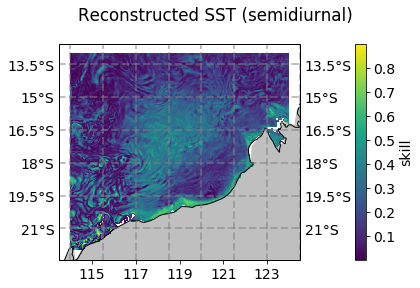

In [47]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_semi.XC,vslow_semi.YC,skill_semi, \
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('Reconstructed SST (semidiurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Skill.png'
frame = graphdir+'movies/Semidiurnal_SST/'+figname
fig.savefig(frame, dpi=150)

## Decompose diurnal component

In [48]:

vslow_diurnal, vfast_diurnal = get_slow_fast(sst2d_2days,omega=omega_M2/2,verbose = True)


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


B: 28.50050294508936 -2.022739082149505e-07 -0.03883979905607715 -0.033313700057481875


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


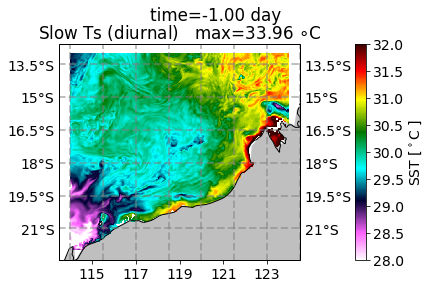

In [49]:
fig = plt.figure()
#plot wave SST
t0=0

pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_diurnal.XC,vslow_diurnal.YC,vslow_diurnal[:,:,t0], \
                transform = ccrs.PlateCarree(),cmap=csst,vmax=32,vmin=28)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C ]')
ax.set_title(r'Slow Ts (diurnal)   max=%.2f $\circ$C' %(np.abs(vslow_diurnal[:,:,t0]).max(skipna=True) ))
thour=(vslow_semi.time[t0]/3600)
tday=(vslow_semi.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

In [50]:
#vslow_diurnal.isel(time=0).plot(vmin=29,vmax=32) #too slow

In [51]:
vslow_diurnal.name = 'SST_slow_diurnal'
vfast_diurnal.name = 'SST_fast_diurnal'

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


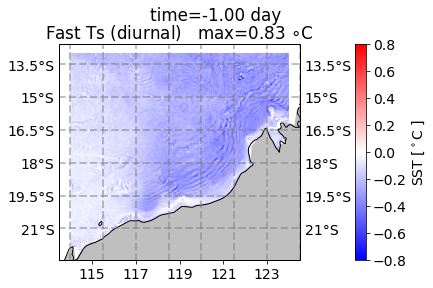

In [52]:
fig = plt.figure()
#plot wave SST
t0=0

pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vfast_diurnal.XC,vfast_diurnal.YC,vfast_diurnal[:,:,t0], \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.8,vmin=-0.8)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C ]')
ax.set_title(r'Fast Ts (diurnal)   max=%.2f $\circ$C' %(np.abs(vfast_diurnal[:,:,t0]).max(skipna=True) ))
thour=(vfast_semi.time[t0]/3600)
tday=(vfast_semi.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

In [53]:
#vfast_diurnal.isel(time=0).plot( cmap = 'bwr')

In [54]:
#vfast_ij_diurnal=vfast_diurnal.sel(i=2985,j=2436)
#vslow_ij_diurnal=vslow_diurnal.sel(i=2985,j=2436)
vfast_ij_diurnal=vfast_diurnal.sel(i=2986,j=2435)
vslow_ij_diurnal=vslow_diurnal.sel(i=2986,j=2435)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


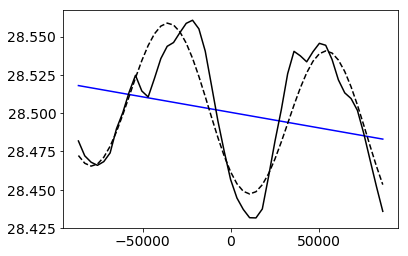

In [55]:
#plt.plot(t,vfast_ij+sst_t_mean,c='r')
plt.plot(t,vslow_ij_diurnal,c='b')
plt.plot(t,sst_t,c='k')
plt.plot(t,vfast_ij_diurnal+vslow_ij_diurnal,c='k',linestyle='--')

In [56]:
sst_t_no_diurnal=sst_t-vfast_ij_diurnal-vslow_ij_diurnal

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


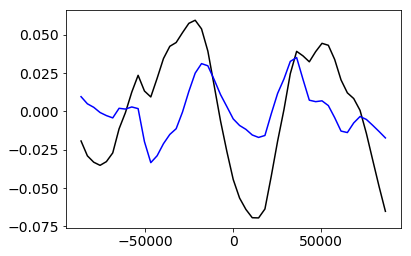

In [57]:
plt.plot(t,sst_t-sst_t_mean,c='k')
plt.plot(t,sst_t_no_diurnal,c='b')

In [58]:
print(sst_t_no_diurnal)

<xarray.DataArray (time: 49)>
dask.array<shape=(49,), dtype=float64, chunksize=(49,)>
Coordinates:
    i        int64 2986
    j        int64 2435
    face     int64 4
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>
    XC       float32 dask.array<shape=(), chunksize=()>
    YC       float32 dask.array<shape=(), chunksize=()>
    rA       float32 dask.array<shape=(), chunksize=()>
    Depth    float32 dask.array<shape=(), chunksize=()>


In [59]:
vslow_semi_no_diurnal, vfast_semi_no_diurnal = get_slow_fast(sst_t_no_diurnal,omega=omega_M2)#, verbose = True)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


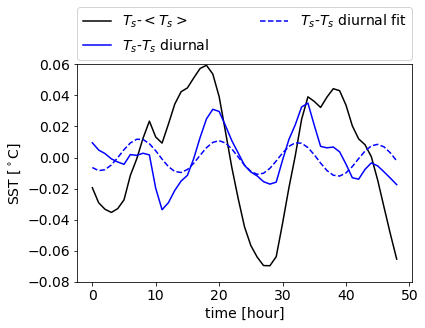

In [60]:
plt.plot(t/3600-t[0]/3600,sst_t-sst_t_mean,c='k',label = r'$T_s$-$<T_s>$')
plt.plot(t/3600-t[0]/3600,sst_t_no_diurnal,c='b',label = r'$T_s$-$T_s$ diurnal')
plt.plot(t/3600-t[0]/3600,vslow_semi_no_diurnal+vfast_semi_no_diurnal,c='b',linestyle='--',label = r'$T_s$-$T_s$ diurnal fit')
plt.ylabel(r'SST [$^\circ$C]')
plt.xlabel('time [hour]')
plt.ylim([-0.08,0.06])
#plt.legend(loc=3,ncol=2)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

### Save NetCDF

In [61]:
file_out = datadir_out+'fast_SST_diurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [62]:
file_out = datadir_out+'slow_SST_diurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [63]:
sst_recons_diurnal= vslow_diurnal+vfast_diurnal
skill_diurnal = skill(sst2d_2days, sst_recons_diurnal)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


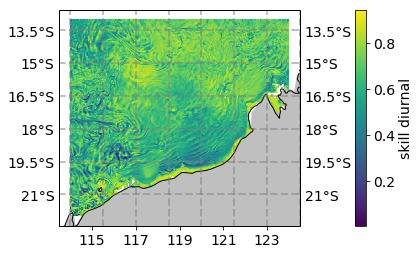

In [64]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(skill_diurnal.XC,skill_diurnal.YC,skill_diurnal, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'skill diurnal')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

In [65]:
#skill_diurnal.plot()


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


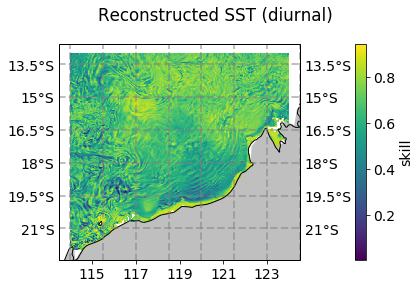

In [66]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_diurnal.XC,vslow_diurnal.YC,skill_diurnal, \
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('Reconstructed SST (diurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Skill.png'
frame = graphdir+'movies/Diurnal_SST/'+figname
fig.savefig(frame, dpi=150)

In [67]:
print('semidiurnal max skill=',np.nanmax(skill_semi.values),'diurnal max sikill:',np.nanmax(skill_diurnal))

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


semidiurnal max skill= 0.8992174652283528 diurnal max sikill: 0.9434343641449265


In [68]:
print(skill_diurnal)

<xarray.DataArray (j: 492, i: 480)>
dask.array<shape=(492, 480), dtype=float64, chunksize=(73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>


### Decompose semidiurnal component after removing diurnal cycle

In [69]:
sst_2d_recons_diurnal = vslow_diurnal + vfast_diurnal
sst2d_2days_no_diurnal = sst2d_2days - sst_2d_recons_diurnal

In [70]:
vslow_semi_no_diurnal, vfast_semi_no_diurnal = get_slow_fast(sst2d_2days_no_diurnal,omega=omega_M2,verbose = True)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


B: -8.958652651923206e-05 -2.6124799162587683e-08 -0.004753560533293477 -0.009450838083527143


In [71]:
vrecons_semi_no_diurnal = vslow_semi_no_diurnal + vfast_semi_no_diurnal

In [72]:
skill_semi_no_diurnal = skill(sst2d_2days_no_diurnal, vrecons_semi_no_diurnal)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


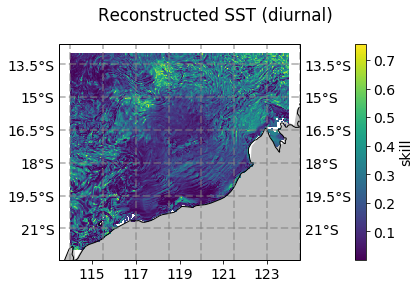

In [73]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(vslow_semi_no_diurnal.XC,vslow_semi_no_diurnal.YC,skill_semi_no_diurnal, \
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('Reconstructed SST (diurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Skill_semi_diurnal_corrected.png'
frame = graphdir+'movies/Semidiurnal_SST_diurnal_corrected/'+figname
fig.savefig(frame, dpi=150)

In [74]:
#skill_semi_no_diurnal.plot()

In [75]:
print(vslow_semi_no_diurnal)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [76]:
vslow_semi_no_diurnal.name = 'SST_slow_semi_diurnal_corrected'
vfast_semi_no_diurnal.name = 'SST_fast_semi_diurnal_corrected'

In [77]:
file_out = datadir_out+'fast_SST_semi_diurnal_corrected.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_semi_no_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [78]:
file_out = datadir_out+'slow_SST_semi_diurnal_corrected.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_semi_no_diurnal.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Decompose semidiurnal and components at the time

In [79]:
vslow_all, vfast_semi_all, vfast_diurnal_all = get_slow_fast(sst2d_2days,omega=omega_M2, omega2=omega_M2/2, verbose = True)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


B: 28.5004097092756 -2.3359133394043835e-07 -0.004760870803640515 -0.009523812941322443 -0.03902634648590908 -0.03420520459810651


In [80]:
vfast_diurnal_all_ij=vfast_diurnal_all.sel(i=2986,j=2435)
vfast_semi_all_ij=vfast_semi_all.sel(i=2986,j=2435)
vslow_all_ij=vslow_all.sel(i=2986,j=2435)
vslow_diurnal_ij=vslow_diurnal.sel(i=2986,j=2435)
vfast_diurnal_ij=vfast_diurnal.sel(i=2986,j=2435)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


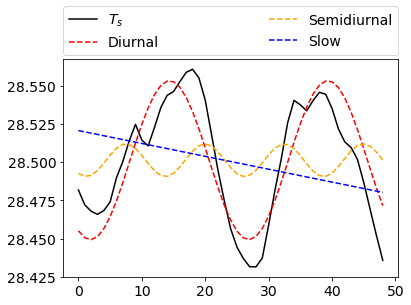

In [81]:
plt.plot(t/3600-t[0]/3600,sst_t,c='k',label = r'$T_s$')
plt.plot(t/3600-t[0]/3600,vfast_diurnal_all_ij+sst_t_mean,c='r',linestyle='--', label='Diurnal')
plt.plot(t/3600-t[0]/3600,vfast_semi_all_ij+sst_t_mean,c='orange',linestyle='--',label='Semidiurnal')
plt.plot(t/3600-t[0]/3600,vslow_all_ij,c='b',linestyle='--',label='Slow')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0,0.5,'SST [$^\\circ$C]')

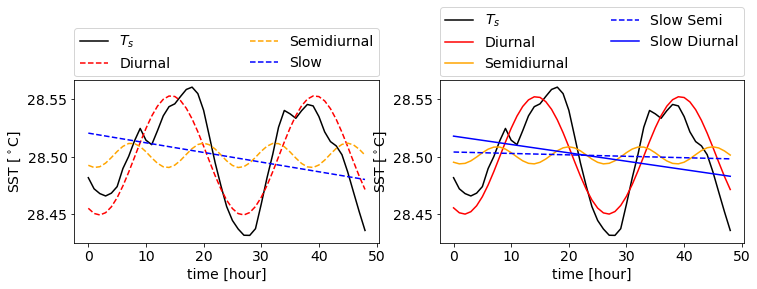

In [82]:
fig = plt.figure(figsize=(12,3))

plt.subplot(121)

ax = fig.add_subplot(121)

ax.plot(t/3600-t[0]/3600,sst_t,c='k',label = r'$T_s$')
ax.plot(t/3600-t[0]/3600,vfast_diurnal_all_ij+sst_t_mean,c='r',linestyle='--', label='Diurnal')
ax.plot(t/3600-t[0]/3600,vfast_semi_all_ij+sst_t_mean,c='orange',linestyle='--',label='Semidiurnal')
ax.plot(t/3600-t[0]/3600,vslow_all_ij,c='b',linestyle='--',label='Slow')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('time [hour]')
plt.ylabel(r'SST [$^\circ$C]')

ax2 = fig.add_subplot(122)
ax2.plot(t/3600-t[0]/3600,sst_t,c='k',label = r'$T_s$')
ax2.plot(t/3600-t[0]/3600,vfast_diurnal_ij+sst_t_mean,c='r', label='Diurnal')
ax2.plot(t/3600-t[0]/3600,vfast_semi_ij+sst_t_mean,c='orange',label='Semidiurnal')
ax2.plot(t/3600-t[0]/3600,vslow_semi_ij,c='b',linestyle='--',label='Slow Semi')
ax2.plot(t/3600-t[0]/3600,vslow_diurnal_ij,c='b',label='Slow Diurnal')
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('time [hour]')
plt.ylabel(r'SST [$^\circ$C]')

In [83]:
sst_reconstructed_all_ij = vfast_diurnal_all_ij + vfast_semi_all_ij + vslow_all_ij
sst_reconstructed_semi_ij = vslow_semi_ij + vfast_semi_ij
sst_reconstucted_diurnal_ij = vslow_diurnal_ij + vfast_diurnal_ij

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0,0.5,'SST [$^\\circ$C]')

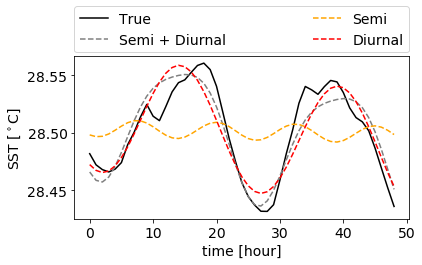

In [84]:
fig = plt.figure(figsize=(6,3))
plt.plot(t/3600-t[0]/3600, sst_t,c='k',label = r'True')
plt.plot(t/3600-t[0]/3600, sst_reconstructed_all_ij,c='gray',linestyle='--',label = r'Semi + Diurnal')
plt.plot(t/3600-t[0]/3600, sst_reconstructed_semi_ij,c='orange',linestyle='--',label = r'Semi')
plt.plot(t/3600-t[0]/3600, sst_reconstucted_diurnal_ij,c='red',linestyle='--',label = r'Diurnal')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('time [hour]')
plt.ylabel(r'SST [$^\circ$C]')

In [85]:
vslow_all.name = 'SST_slow_all'
vfast_semi_all.name = 'SST_fast_semi_all'
vfast_diurnal_all.name = 'SST_fast_diurnal_all'

In [86]:
sst_reconstructed_all = vfast_diurnal_all + vfast_semi_all + vslow_all

In [87]:
skill_semi_diurnal_all = skill(sst2d_2days, sst_reconstructed_all)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


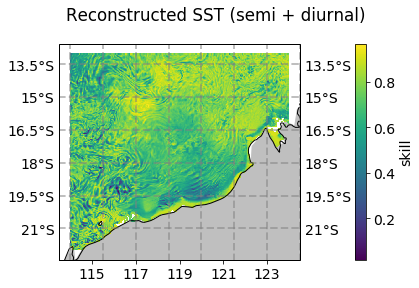

In [88]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(skill_semi_diurnal_all.XC,skill_semi_diurnal_all.YC,skill_semi_diurnal_all, \
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('Reconstructed SST (semi + diurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Skill_semi_diurnal_all.png'
frame = graphdir+'movies/SST_semi_diurnal_all/'+figname
fig.savefig(frame, dpi=150)

In [89]:
file_out = datadir_out+'slow_SST_all.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vslow_all.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [90]:
file_out = datadir_out+'fast_SST_semi_all.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_semi_all.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [91]:
file_out = datadir_out+'fast_SST_diurnal_all.nc'
if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
vfast_diurnal_all.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


---

### Compute Residual

In [92]:
SST_residual = sst2d_2days - sst_reconstructed_all

In [93]:
print(SST_residual)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float64, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


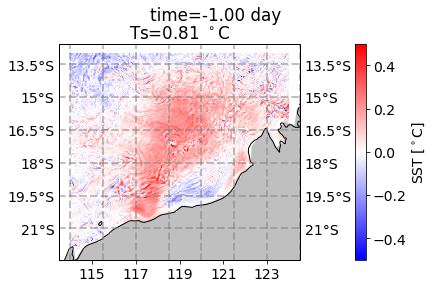

In [94]:
fig = plt.figure()
#plot wave SST

t0=0
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(SST_residual.XC,SST_residual.YC,SST_residual[t0,:,:], \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')
ax.set_title(r'Ts=%.2f $^\circ$C' %(np.abs(SST_residual[t0,:,:]).max(skipna=True) ))
thour=(SST_residual.time[t0]/3600)
tday=(SST_residual.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='SST_residual_'+str(int(thour.values))+'.png'
frame = graphdir+'movies/SST_residual_all/'+figname
fig.savefig(frame, dpi=150)

In [95]:
Frame = True
if(Frame):
    Nt=SST_residual.time.size
    for t0 in range(Nt):
        fig = plt.figure()
        pad = 0.15
        ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
        #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
        cs = ax.pcolormesh(SST_residual.XC,SST_residual.YC,SST_residual[t0,:,:], \
                        transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
        cbar = fig.colorbar(cs, ax=ax, pad=pad)
        #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
        cbar.set_label(r'SST [$^\circ$C]')
        ax.set_title(r'Ts=%.2f m s$^{-1}$' %(np.abs(SST_residual[t0,:,:]).max(skipna=True) ))
        thour=(SST_residual.time[t0]/3600)
        tday=(SST_residual.time[t0]/(3600*24.))
        title=str(tday.values)
        fig.suptitle('time=%.2f day'%(tday.values))
        plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
        figname='SST_residual_'+str(int(thour.values))+'.png'
        frame = graphdir+'movies/SST_residual_all/'+figname
        fig.savefig(frame, dpi=150)
        plt.close(fig)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


--- 

### Difference between skill all and skill diurnal

In [96]:
diff_skill_diurnal = skill_semi_diurnal_all - skill_diurnal

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


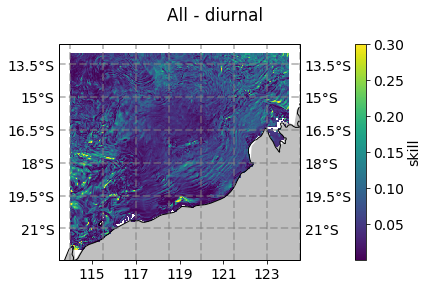

In [97]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(skill_semi_diurnal_all.XC,skill_semi_diurnal_all.YC,diff_skill_diurnal, \
                transform = ccrs.PlateCarree(), vmax = 0.3)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('All - diurnal')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Diff_Skill_diurnal_all.png'
frame = graphdir+'movies/SST_semi_diurnal_all/'+figname
fig.savefig(frame, dpi=150)

In [98]:
inc_skill_diurnal = (skill_semi_diurnal_all/skill_diurnal -1)*100

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


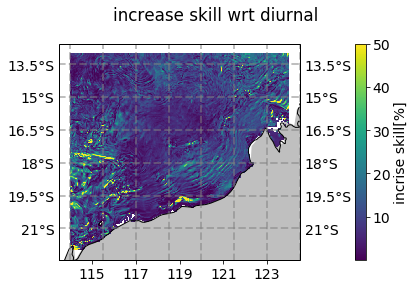

In [99]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(skill_semi_diurnal_all.XC,skill_semi_diurnal_all.YC,inc_skill_diurnal, \
                transform = ccrs.PlateCarree(),vmax = 50)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('increase skill wrt diurnal')
cbar.set_label(r'incrise skill[%]')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Increase_Skill_diurnal_all.png'
frame = graphdir+'movies/SST_semi_diurnal_all/'+figname
fig.savefig(frame, dpi=150)

In [100]:
inc_skill_semi = (skill_semi_diurnal_all/skill_semi -1)*100

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n


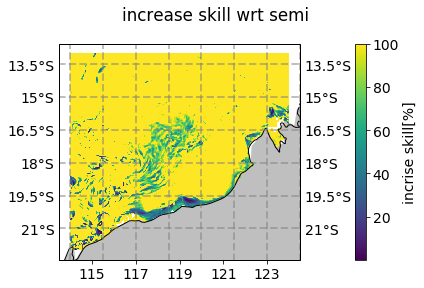

In [101]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(skill_semi_diurnal_all.XC,skill_semi_diurnal_all.YC,inc_skill_semi, \
                transform = ccrs.PlateCarree(), vmax = 100)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('increase skill wrt semi')
cbar.set_label(r'incrise skill[%]')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='Increase_Skill_semi_all.png'
frame = graphdir+'movies/SST_semi_diurnal_all/'+figname
fig.savefig(frame, dpi=150)

---

### Temporal difference 

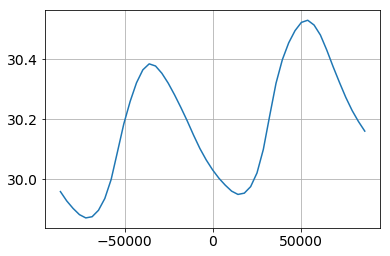

In [102]:
plt.plot(t,Tmean_xy_2days)
plt.grid()

In [103]:
Tmean_xy_recontructed = sst_reconstructed_all.mean(dim=['i','j'])

In [104]:
tplot = t/3600-t[0]/3600

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


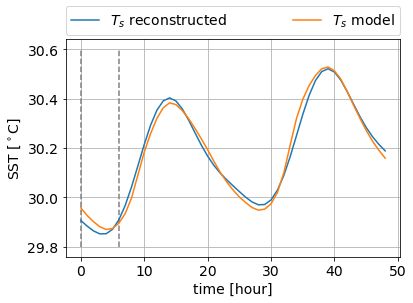

In [105]:
deltat=6
plt.plot(tplot,Tmean_xy_recontructed, label = r'$T_s$ reconstructed')
plt.plot(tplot,Tmean_xy_2days, label = r'$T_s$ model')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('time [hour]')
plt.ylabel(r'SST [$^\circ$C]')
plt.vlines(tplot[0], 29.8, 30.6, colors='gray', linestyles='dashed')
plt.vlines(tplot[0+deltat], 29.8, 30.6, colors='gray', linestyles='dashed')
plt.grid()

In [106]:
print(sst_reconstructed_all)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [107]:
print(sst2d_2days)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float32, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [108]:
t0 = 0
deltat = 12
deltaT_recons= sst_reconstructed_all[:,:,t0+deltat]-sst_reconstructed_all[:,:,t0]

In [109]:
deltaT_model = sst2d_2days[t0+deltat,:,:] - sst2d_2days[t0,:,:]

In [110]:
print(deltaT_recons)

<xarray.DataArray (j: 492, i: 480)>
dask.array<shape=(492, 480), dtype=float64, chunksize=(73, 480)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>


In [111]:
Nt = t.size
print(Nt)

49


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


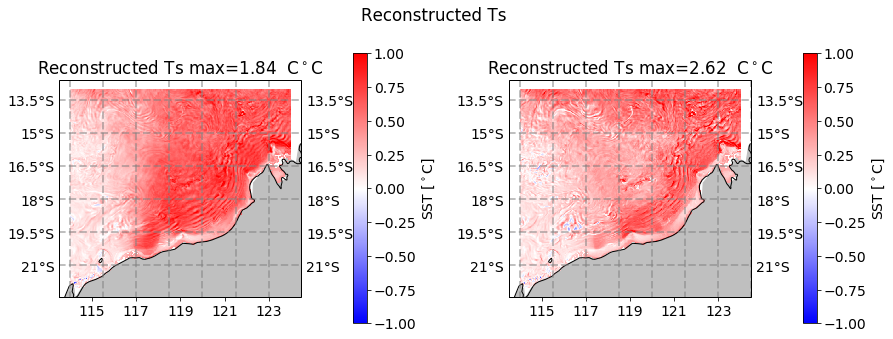

In [112]:
fig = plt.figure(figsize=(13,5))
pad = 0.15
ax = make_cartopy(1,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(deltaT_recons.XC,deltaT_recons.YC,deltaT_recons, \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=-1,vmin=1)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')
fig.suptitle('Reconstructed Ts')
ax.set_title(r'Reconstructed Ts max=%.2f  C$^\circ$C' %(np.abs(deltaT_recons).max(skipna=True) ))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

ax = make_cartopy(1,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(deltaT_model.XC,deltaT_model.YC,deltaT_model, \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=-1,vmin=1)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')
ax.set_title(r'Reconstructed Ts max=%.2f  C$^\circ$C' %(np.abs(deltaT_model).max(skipna=True) ))
#ax.set_title(r'Ts=%.2f m s$^{-1}$' %(np.abs(deltaT_model).max(skipna=True) ))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


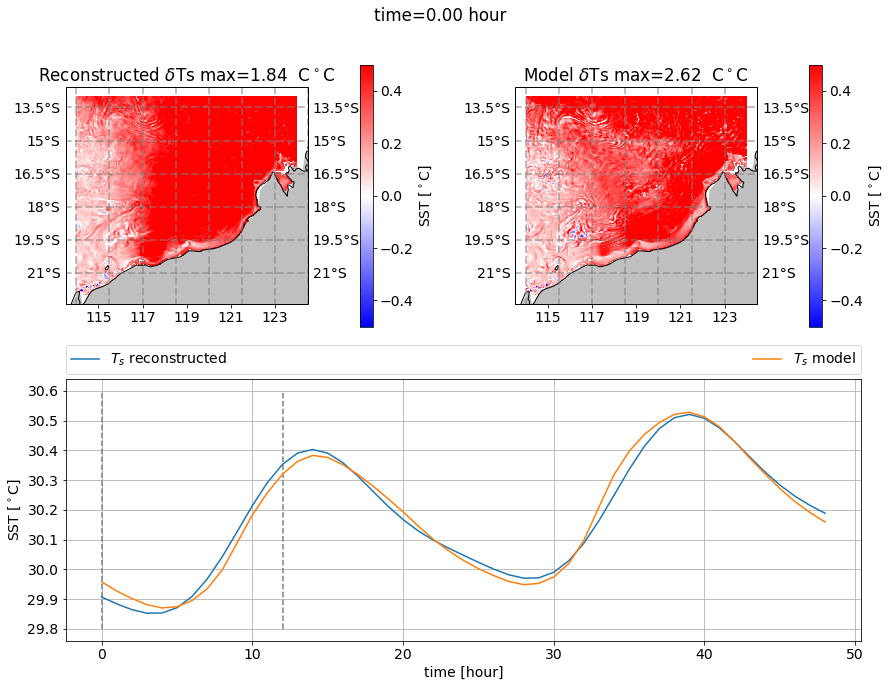

In [113]:
fig = plt.figure(figsize=(13,10))
pad = 0.15
ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(deltaT_recons.XC,deltaT_recons.YC,deltaT_recons, \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')

ax.set_title(r'Reconstructed $\delta$Ts max=%.2f  C$^\circ$C' %(np.abs(deltaT_recons).max(skipna=True) ))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(deltaT_model.XC,deltaT_model.YC,deltaT_model, \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')
ax.set_title(r'Model $\delta$Ts max=%.2f  C$^\circ$C' %(np.abs(deltaT_model).max(skipna=True) ))



ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(tplot,Tmean_xy_recontructed, label = r'$T_s$ reconstructed')
ax3.plot(tplot,Tmean_xy_2days, label = r'$T_s$ model')
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
ax3.set_xlabel('time [hour]')
ax3.set_ylabel(r'SST [$^\circ$C]')
ax3.vlines(tplot[0], 29.8, 30.6, colors='gray', linestyles='dashed')
ax3.vlines(tplot[0+deltat], 29.8, 30.6, colors='gray', linestyles='dashed')
plt.grid()

thour=(sst_reconstructed_all.time[t0]/3600)
thour_plot=(tplot[t0]/3600)
tday=(sst_reconstructed_all.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f hour'%(thour_plot))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.2,wspace=0.3,top=0.9,bottom=0.1)
figname='deltaT'+str(int(thour.values))+'.png'
frame = graphdir+'movies/deltaSST/'+str(deltat)+'h/'+figname
fig.savefig(frame, dpi=150)
#plt.close(fig)

In [114]:
Nt=t.size
print(Nt)

49


In [115]:
thour_plot=(tplot)

In [116]:
print(tplot.values)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

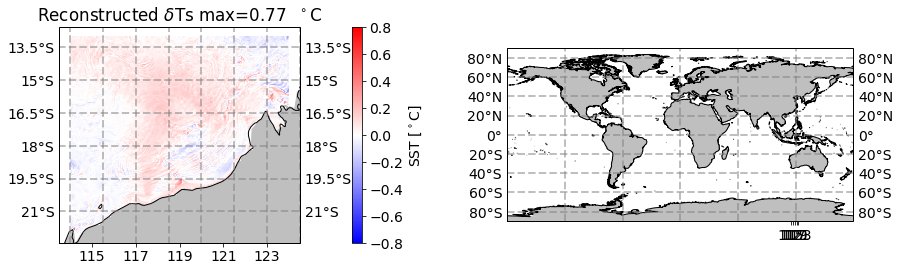

In [117]:
deltat=3
for t0 in range(Nt - deltat):
    
    deltaT_recons= sst_reconstructed_all[:,:,t0+deltat]-sst_reconstructed_all[:,:,t0]
    deltaT_model = sst2d_2days[t0+deltat,:,:] - sst2d_2days[t0,:,:]
    
    fig = plt.figure(figsize=(13,10))
    pad = 0.15
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
    #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.pcolormesh(deltaT_recons.XC,deltaT_recons.YC,deltaT_recons, \
                    transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.8,vmin=-0.8)
    cbar = fig.colorbar(cs, ax=ax, pad=pad)
    #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
    cbar.set_label(r'SST [$^\circ$C]')

    ax.set_title(r'Reconstructed $\delta$Ts max=%.2f  $^\circ$C' %(np.abs(deltaT_recons).max(skipna=True) ))
    plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2, lonticks = [115,117,119,121,123])
    #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.pcolormesh(deltaT_model.XC,deltaT_model.YC,deltaT_model, \
                    transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.8,vmin=-0.8)
    cbar = fig.colorbar(cs, ax=ax, pad=pad)
    #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
    cbar.set_label(r'SST [$^\circ$C]')
    ax.set_title(r'Model $\delta$Ts max=%.2f  $^\circ$C' %(np.abs(deltaT_model).max(skipna=True) ))
    #ax.set_title(r'Ts=%.2f m s$^{-1}$' %(np.abs(deltaT_model).max(skipna=True) ))

    plt.subplots_adjust(left=0.1,right=0.95,hspace=0.2,wspace=0.3,top=0.9,bottom=0.1)

 
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    ax3.plot(tplot,Tmean_xy_recontructed, label = r'$T_s$ reconstructed')
    ax3.plot(tplot,Tmean_xy_2days, label = r'$T_s$ model')
    ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
    ax3.set_xlabel('time [hour]')
    ax3.set_ylabel(r'SST [$^\circ$C]')
    ax3.vlines(tplot[t0], 29.8, 30.6, colors='gray', linestyles='dashed')
    ax3.vlines(tplot[t0+deltat], 29.8, 30.6, colors='gray', linestyles='dashed')
    plt.grid()

    thour=(sst_reconstructed_all.time[t0]/3600)
    tday=(sst_reconstructed_all.time[t0]/(3600*24.)-sst_reconstructed_all.time[0]/(3600*24.))
    thour_plot=(tplot[t0])
    title=str(tday.values)
    fig.suptitle('time=%02d hour'%(tplot[t0].values))
    figname='deltaT'+str(int(thour.values))+'.png'
    frame = graphdir+'movies/deltaSST/'+str(deltat)+'h/'+figname
    fig.savefig(frame, dpi=150)
    plt.close(fig)

### Modify harmonic decomposition - return all coefficients

In [118]:
vslow_all, vsemi_all, vfast_diurnal_all, mean_ts,trend_ts, cos_M2, sin_M2, cos_diurnal, sin_diurnal = get_slow_fast(sst2d_2days,omega=omega_M2, omega2=omega_M2/2, verbose = True,coeff = True)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


B: 28.5004097092756 -2.3359133394043835e-07 -0.004760870803640515 -0.009523812941322443 -0.03902634648590908 -0.03420520459810651


In [119]:
-2.335913339492194e-07*3600*24

-0.020182291253212557

In [120]:
print(sin_diurnal)

<xarray.DataArray (j: 492, i: 480)>
dask.array<shape=(492, 480), dtype=float64, chunksize=(73, 480)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


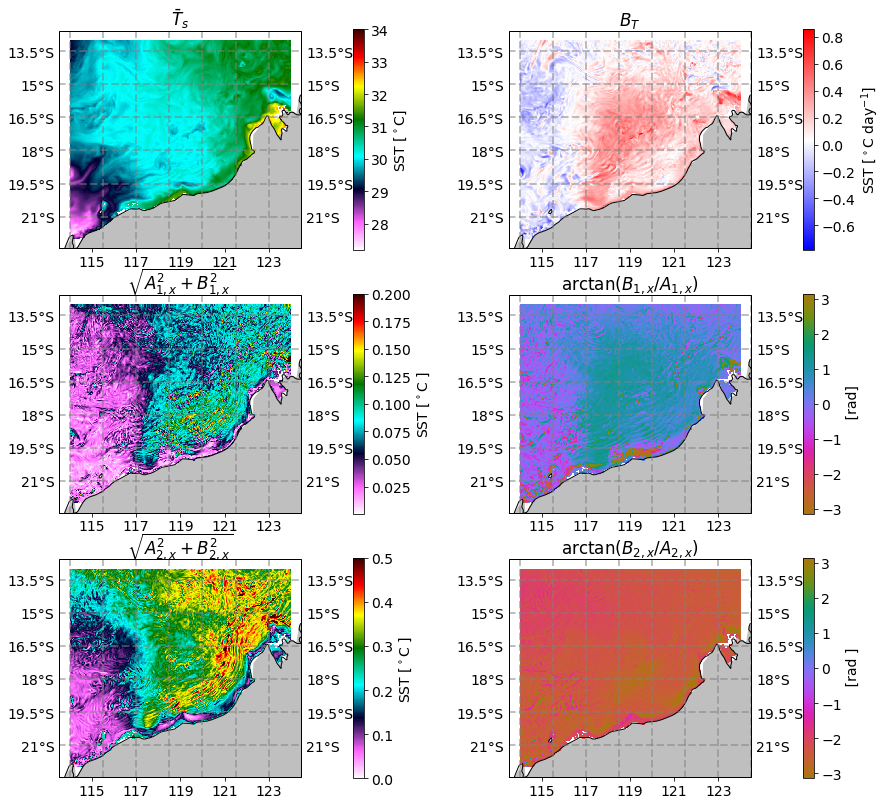

In [124]:
fig = plt.figure(figsize=(13,13))
pad = 0.15
ax = make_cartopy(3,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(mean_ts.XC,mean_ts.YC,mean_ts, \
                transform = ccrs.PlateCarree(),cmap=csst)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')

ax.set_title(r'$\bar{T}_s$')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

ax = make_cartopy(3,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(trend_ts.XC,trend_ts.YC,trend_ts*3600*24, \
                transform = ccrs.PlateCarree(),cmap='bwr')#, vmax = 0.1, vmin = -0.1),vmax=-0.5,vmin=0.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C day$^{-1}$]')
ax.set_title(r'$B_T$')

ax = make_cartopy(3,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=3, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(cos_M2.XC,cos_M2.YC,np.sqrt(cos_M2**2 + sin_M2**2), \
                transform = ccrs.PlateCarree(),cmap=csst,vmax=0.2)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C ]')
#ax.set_title(r'$\cos (\omega_{M2})$' )
ax.set_title(r'$ \sqrt{A_{1,x}^2 + B_{1,x}^2}$' )

ax = make_cartopy(3,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=4, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(sin_M2.XC,sin_M2.YC,np.arctan2(sin_M2,cos_M2), \
                transform = ccrs.PlateCarree(),cmap=cmocean.cm.phase)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r' [rad]')
#ax.set_title(r'$\sin (\omega_{M2})$' )
ax.set_title(r'$\arctan (B_{1,x} / A_{1,x})$' )


ax = make_cartopy(3,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=5, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(cos_diurnal.XC,cos_diurnal.YC,np.sqrt(cos_diurnal**2+sin_diurnal**2), \
                transform = ccrs.PlateCarree(),cmap=csst, vmax = 0.5, vmin = 0)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C ]')
ax.set_title(r'$ \sqrt{A_{2,x}^2 + B_{2,x}^2}$' )

ax = make_cartopy(3,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=6, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(sin_diurnal.XC,sin_diurnal.YC,np.arctan2(sin_diurnal,cos_diurnal), \
                transform = ccrs.PlateCarree(),cmap=cmocean.cm.phase)#,vmax = 0.8,vmin = -0.8)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r' [rad ]')
#ax.set_title(r'$\sin (\omega_{M2}/2)$' )
ax.set_title(r'$\arctan (B_{2,x} / A_{2,x})$' )

plt.subplots_adjust(left=0.1,right=0.95,hspace=0.2,wspace=0.3,top=0.9,bottom=0.1)
figname = graphdir+'Harmonic_Analysis.png'
fig.savefig(figname, dpi=150)


In [140]:
vslow_all2 = mean_ts + trend_ts*t
print(vslow_all2)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [139]:
print(vslow_all)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


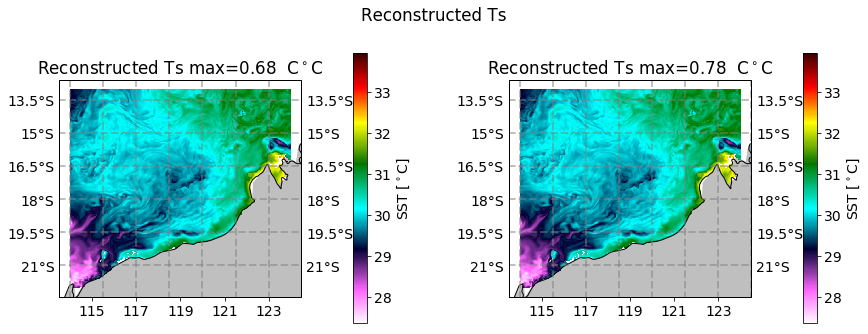

In [143]:
## compare vslow with mean +  trend*t


fig = plt.figure(figsize=(13,5))
pad = 0.15
ax = make_cartopy(1,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
cs = ax.pcolormesh(vslow_all[:,:,0].XC,vslow_all[:,:,0].YC,vslow_all[:,:,0], \
                transform = ccrs.PlateCarree(),cmap=csst)#,vmax=-1,vmin=1)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
cbar.set_label(r'SST [$^\circ$C]')
fig.suptitle('Reconstructed Ts')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

ax = make_cartopy(1,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2, lonticks = [115,117,119,121,123])
cs = ax.pcolormesh(vslow_all2[:,:,0].XC,vslow_all2[:,:,0].YC,vslow_all2[:,:,0], \
                transform = ccrs.PlateCarree(),cmap=csst)#,vmax=-1,vmin=1)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'SST [$^\circ$C]')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

In [147]:
SST_model_anomaly  = sst2d_2days - vslow_all

In [148]:
print(SST_model_anomaly)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float64, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [149]:
Tmean_xy_anomaly =SST_model_anomaly.mean(dim=['i','j'])
Tmean_semi = vsemi_all.mean(dim=['i','j'])
Tmean_diurnal = vfast_diurnal_all.mean(dim=['i','j'])

In [152]:
print(deltaT_diurnal)

<xarray.DataArray (i: 480, time: 49)>
dask.array<shape=(480, 49), dtype=float64, chunksize=(480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
    XC       (i) float32 dask.array<shape=(480,), chunksize=(480,)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [159]:
deltat=12
for t0 in range(Nt - deltat):
    deltaT_semi= vsemi_all[:,:,t0+deltat]-vsemi_all[:,:,t0]
    deltaT_diurnal = vfast_diurnal_all[:,:,t0+deltat] - vfast_diurnal_all[:,:,t0]

    fig = plt.figure(figsize=(13,10))
    pad = 0.15
    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
    #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.pcolormesh(deltaT_semi.XC,deltaT_semi.YC,deltaT_semi, \
                    transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.4,vmin=-0.4)
    cbar = fig.colorbar(cs, ax=ax, pad=pad)
    #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
    cbar.set_label(r'SST [$^\circ$C]')

    ax.set_title(r'Semidiurnal $\delta$Ts max=%.2f  $^\circ$C' %(np.abs(deltaT_semi).max(skipna=True) ))
    plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)

    ax = make_cartopy(2,2,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=2, lonticks = [115,117,119,121,123])
    #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.pcolormesh(deltaT_diurnal.XC,deltaT_diurnal.YC,deltaT_diurnal, \
                    transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.4,vmin=-0.4)
    cbar = fig.colorbar(cs, ax=ax, pad=pad)
    #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
    cbar.set_label(r'SST [$^\circ$C]')
    ax.set_title(r'Diurnal $\delta$Ts max=%.2f  $^\circ$C' %(np.abs(deltaT_diurnal).max(skipna=True) ))


    plt.subplots_adjust(left=0.1,right=0.95,hspace=0.2,wspace=0.3,top=0.9,bottom=0.1)


    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    ax3.plot(tplot,Tmean_xy_anomaly, label = r'$T_s$ model -$T_s$ slow')
    ax3.plot(tplot,Tmean_semi, label = r'$T_s$ semidiurnal')
    ax3.plot(tplot,Tmean_diurnal, label = r'$T_s$ diurnal')
    ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    ax3.set_xlabel('time [hour]')
    ax3.set_ylabel(r'SST [$^\circ$C]')
    ax3.vlines(tplot[t0], -0.3, 0.3, colors='gray', linestyles='dashed')
    ax3.vlines(tplot[t0+deltat], -0.3, 0.3, colors='gray', linestyles='dashed')
    plt.grid()

    thour=(sst_reconstructed_all.time[t0]/3600 + 24)
    tday=(sst_reconstructed_all.time[t0]/(3600*24.)-sst_reconstructed_all.time[0]/(3600*24.))
    thour_plot=(tplot[t0])
    title=str(tday.values)
    fig.suptitle('time=%02d hour'%(tplot[t0].values))
    figname='deltaT_semi_diurnal'+str(int(thour.values))+'.png'
    frame = graphdir+'movies/deltaTs_semi_diurnal/'+str(deltat)+'h/'+figname
    fig.savefig(frame, dpi=150)
    plt.close(fig)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [128]:

Tmean_xy_slow = vslow_all.mean(dim=['i','j'])
print(Tmean_xy_slow)

<xarray.DataArray (time: 49)>
dask.array<shape=(49,), dtype=float64, chunksize=(49,)>
Coordinates:
    face     int64 4
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [144]:
deltat = 6

for t0 in range(Nt - deltat):
    deltaT_slow= vslow_all[:,:,t0+deltat]-vslow_all[:,:,t0]


    fig = plt.figure(figsize=(13,10))
    pad = 0.15
    ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
    #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
    cs = ax.pcolormesh(deltaT_slow.XC,deltaT_slow.YC,deltaT_slow, \
                    transform = ccrs.PlateCarree(),cmap='bwr',vmax=0.4,vmin=-0.4)
    cbar = fig.colorbar(cs, ax=ax, pad=pad)
    #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
    cbar.set_label(r'SST [$^\circ$C]')






    #ax3 = fig.add_subplot(2,1,2)
    #ax3.plot(tplot,Tmean_xy_recontructed, label = r'$T_s$ reconstructed')
    #ax3.plot(tplot,Tmean_xy_2days, label = r'$T_s$ model')
    #ax3.plot(tplot,Tmean_xy_slow, label = r'$T_s$ slow')
    #ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    #ax3.set_xlabel('time [hour]')
    #ax3.set_ylabel(r'SST [$^\circ$C]')
    #ax3.vlines(tplot[0], 29.8, 30.6, colors='gray', linestyles='dashed')
    #ax3.vlines(tplot[0+deltat], 29.8, 30.6, colors='gray', linestyles='dashed')
    #plt.grid()

    thour=(sst_reconstructed_all.time[t0]/3600 + 24)
    tday=(sst_reconstructed_all.time[t0]/(3600*24.)-sst_reconstructed_all.time[0]/(3600*24.))
    thour_plot=(tplot[t0])
    title=str(tday.values)
    fig.suptitle(r'time=%02d hour $\Delta t = %02d$'%(tplot[t0].values,deltat))
    figname='deltaTs_slow'+str(int(thour.values))+'.png'
    frame = graphdir+'movies/deltaTs_slow/'+str(deltat)+'h/'+figname
    fig.savefig(frame, dpi=150)
    plt.close(fig)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [141]:
sst_reconstructed_all.time/3600

<xarray.DataArray 'time' (time: 49)>
array([-24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14., -13.,
       -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
         0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.])
Coordinates:
    face     int64 4
  * time     (time) float64 -8.64e+04 -8.28e+04 -7.92e+04 -7.56e+04 -7.2e+04 ...
    dtime    (time) datetime64[ns] dask.array<shape=(49,), chunksize=(49,)>
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>